# GOFevaluation Tutorial
Robert Hammann, Tim Wolf  
October 2021

A Goodness-of-fit (GOF) test is a powerful statistical tool to quantify the degree of agreement between experimental data and a fit to the data. For multivariate analyses, unbinned (two-sample) GOF tests are of particular interest. Unlike binned GOF tests, they do not suffer from the curse of dimensionality that forces the use of coarse binning due to a thinly populated parameter space in high dimensions.  
Selecting a GOF measure that reliably identifies a mismodelling in your specific analysis is not always straightforward. The GOFevaluation package aims to streamline the process of performing GOF tests. It can also be used to conveniently study of the performance of different GOF measures as discussed in [this](https://arxiv.org/abs/1006.3019) paper from M. Williams.   
This GOF suite comprises the possibility to calculate different 1D / nD, binned / unbinned GOF measures and the p-value of the observed test statistic. The following tests are currently implemented:

| GoF measure                   | Class                     |    data input   | reference input | dim |
|-------------------------------|---------------------------|:---------------:|:---------------:|:---:|
| Kolmogorov-Smirnov            | `KSTestGOF`               |      sample     |      binned     |  1D |
| Two-Sample Kolmogorov-Smirnov | `KSTestTwoSampleGOF`      |      sample     |      sample     |  1D |
| Two-Sample Anderson-Darling   | `ADTestTwoSampleGOF`      |      sample     |      sample     |  1D |
| Poisson Chi2                  | `BinnedPoissonChi2GOF`    | binned / sample |      binned     |  nD |
| Chi2                          | `BinnedChi2GOF`           | binned / sample |      binned     |  nD |
| Point-to-point                | `PointToPointGOF`         |      sample     |      sample     |  nD |

Each GOF test is implemented as a class. In the following, we call an instance of such a class `gof_object`. Depending on whether you want to perform a binned or unbinned test and whether your data and references are in binned or unbinned format, there are several ways to initialize a `gof_object` (discussed in section 1).  
You can also perform multiple GOF tests in parallel with a wrapper class (discussed in section 2).

In [1]:
import GOFevaluation as ge
import scipy.stats as sps
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

In [2]:
mpl.rcParams['figure.dpi'] = 130
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 9

## 0. Generate some fake data for this tutorial

In [3]:
n_data_sample = 150

# reference 0 is drawn from the same distribution as the data ('good fit'), 
# 1 is shifted wrt the true distribution ('bad fit')
data_model = sps.multivariate_normal(mean=[0, 0], cov=[[2, 1], [1, 1]])
ref_model_0 = data_model
ref_model_1 = sps.multivariate_normal(mean=[0, .7], cov=[[2, 1], [1, 1]])

# Draw samples:
data_sample = data_model.rvs(n_data_sample, random_state=40)
reference_sample_0 = ref_model_0.rvs(n_data_sample*100, random_state=41)
reference_sample_1 = ref_model_1.rvs(n_data_sample*100, random_state=42)

# Bin Data & Reference
bin_edges = np.array([np.linspace(-5, 5, 6)]*2)
bin_center_pts = np.array([(bin_edges[0][:-1] + bin_edges[0][1:]) / 2,
(bin_edges[1][:-1] + bin_edges[1][1:]) / 2])
x, y = np.meshgrid(bin_center_pts[0], bin_center_pts[1])
bin_centers = np.vstack([x.reshape(-1), y.reshape(-1)]).T

#binned_reference_0, _ = np.histogramdd(reference_sample_0, bins=bin_edges)
#binned_reference_1, _ = np.histogramdd(reference_sample_1, bins=bin_edges)
binned_data, _ = np.histogramdd(data_sample, bins=bin_edges)

# expectations:
n_expectations = n_data_sample

pdf_0 = ref_model_0.pdf(bin_centers)
pdf_0 /= np.sum(pdf_0)
pdf_0 = pdf_0.reshape(np.shape(binned_data))
expectations_0 = pdf_0 * n_expectations

pdf_1 = ref_model_1.pdf(bin_centers)
pdf_1 /= np.sum(pdf_1)
pdf_1 = pdf_1.reshape(np.shape(binned_data))
expectations_1 = pdf_1 * n_expectations

Let's have a look at the data and our two "fits"!

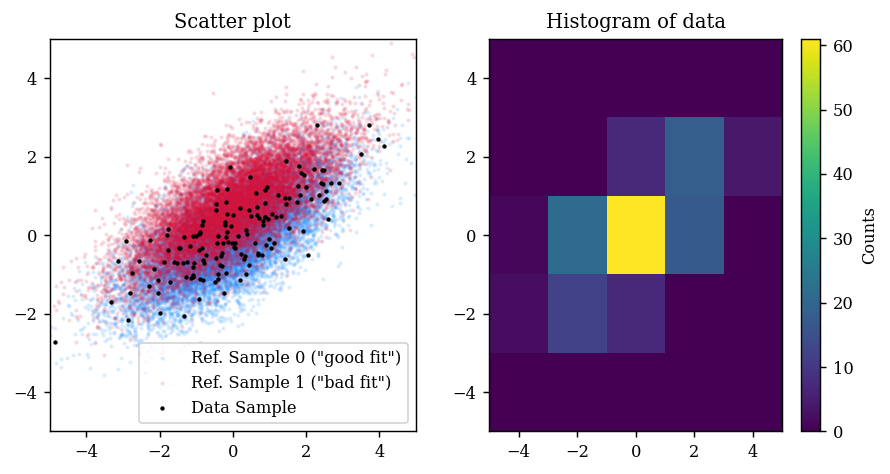

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].scatter(reference_sample_0.T[0], reference_sample_0.T[1], s=2, 
                c='dodgerblue', alpha=.1, label='Ref. Sample 0 ("good fit")')
axes[0].scatter(reference_sample_1.T[0], reference_sample_1.T[1], s=2,
                c='crimson', alpha=.1, label='Ref. Sample 1 ("bad fit")')
axes[0].scatter(data_sample.T[0], data_sample.T[1], s=2, c='k', 
                label='Data Sample')

h = axes[1].hist2d(data_sample.T[0], data_sample.T[1], bins=bin_edges)
fig.colorbar(h[3], ax=axes[1], label='Counts')
axes[0].legend()
axes[0].set_title('Scatter plot')
axes[1].set_title('Histogram of data')

for ax in axes:
    ax.set_xlim(bin_edges[0].min(), bin_edges[0].max())
    ax.set_ylim(bin_edges[1].min(), bin_edges[1].max())

plt.show()

## 1. Make a simple GOF test

There are multiple ways to initialize a GOF test depending on the kind of data that you want to use as an input. A few options are shown in the next few cells. All of them have in common that they create an instance of a class corresponding to the respective GOF test.  
For all of these instances, the method `.get_pvalue()` can then be used to calculate the test statistic and p-value of the test. If you are only interested in the value of the test statistic, you can use the `.get_gof()` method. The `get_pvalue()` method returns the p-value of the test, however you can also access both the observed test statistic and the p-value of the test from the class member: `gof_object.gof`and `gof_object.pvalue`.

### 1.1 Regular init

**For binned GOF tests:** initialize with data sample, binned PDF, bin edges and the total number of expected events. The data sample is then binned internally.

In [5]:
for i, pdf in enumerate([pdf_0, pdf_1]):
    gof_object = ge.BinnedPoissonChi2GOF(data_sample=data_sample,
                                         pdf=pdf,
                                         bin_edges=bin_edges,
                                         nevents_expected=n_expectations)
    gof_object.get_pvalue()
    print(f'\033[1mReference {i}\033[0m')
    print(f'GOF = {gof_object.gof:.2f}')
    print(f'p-value = {gof_object.pvalue:.2f}\n')

/home/hammann/GOFevaluation/GOFevaluation/evaluators_nd.py:86: UserWarning: Binned reference contains bin counts ranging over multiple orders of magnitude (3.94e-16 - 9.28e+01). GoF might be flawed!
  gof = self.calculate_gof(self.binned_data, self.binned_reference)
/home/hammann/GOFevaluation/GOFevaluation/evaluator_base.py:153: UserWarning: Binned reference contains bin counts ranging over multiple orders of magnitude (3.94e-16 - 9.28e+01). GoF might be flawed!
  fake_gofs[i] = self.calculate_gof(
/home/hammann/GOFevaluation/GOFevaluation/evaluator_base.py:189: UserWarning: p-value is 0.0. (Observed GoF: 2.31e+02, maximum of simulated GoFs: 3.19e+01). For a more precise result, increase n_mc!
  pvalue, _ = self._get_pvalue(n_mc=n_mc)
/home/hammann/GOFevaluation/GOFevaluation/evaluators_nd.py:86: UserWarning: Binned reference contains bin counts ranging over multiple orders of magnitude (5.69e-20 - 5.95e+01). GoF might be flawed!
  gof = self.calculate_gof(self.binned_data, self.binne

Reference 0
GOF = 230.58
p-value = 0.00

Reference 1
GOF = 363.91
p-value = 0.00



/home/hammann/GOFevaluation/GOFevaluation/evaluator_base.py:189: UserWarning: p-value is 0.0. (Observed GoF: 3.64e+02, maximum of simulated GoFs: 3.08e+01). For a more precise result, increase n_mc!
  pvalue, _ = self._get_pvalue(n_mc=n_mc)


Another way to show the results of the test is to use `print(gof_object)`, which will print the return of the `__str__` of the class:

In [6]:
print(gof_object)

GOFevaluation.evaluators_nd
BinnedPoissonChi2GOF
gof = 363.90846372129437
p-value = 0.0


The problem with this test is that the regular binning causes expectation values in the bins that range over multiple orders of magnitude. This can make the GOF test unreliable, a better option is to use an equiprobable binning (see section 1.3)

**For unbinned tests:** initialize with data sample and reference sample

In [7]:
# perform a 1D test here:
for i, reference_sample in enumerate([reference_sample_0, reference_sample_1]):
    gof_object = ge.ADTestTwoSampleGOF(data_sample=data_sample.T[1],
                                    reference_sample=reference_sample.T[1])

    gof_object.get_pvalue()
    print(f'\033[1mReference {i}\033[0m')
    print(f'GOF = {gof_object.gof:.2f}')
    print(f'p-value = {gof_object.pvalue:.2f}\n')

Reference 0
GOF = -0.60
p-value = 0.72

Reference 1
GOF = 39.87
p-value = 0.00



/home/hammann/GOFevaluation/GOFevaluation/evaluator_base.py:302: UserWarning: p-value is 0.0. (Observed GoF: 3.99e+01, maximum of simulated GoFs: 7.23e+00). For a more precise result, increase n_mc!
  pvalue, _ = self._get_pvalue(n_perm=n_perm, d_min=d_min)


### 1.2 Initialize with binned data

**For binned GOF tests:** initialize with binned data and binned reference (the binning for both should of course be the same).

In [8]:
for i, expectations in enumerate([expectations_0, expectations_1]):
    gof_object = ge.BinnedPoissonChi2GOF.from_binned(binned_data=binned_data, 
                                                     binned_reference=expectations)
    gof_object.get_pvalue()
    print(f'\033[1mReference {i}\033[0m')
    print(f'GOF = {gof_object.gof:.2f}')
    print(f'p-value = {gof_object.pvalue:.2f}\n')

/home/hammann/GOFevaluation/GOFevaluation/evaluators_nd.py:86: UserWarning: Binned reference contains bin counts ranging over multiple orders of magnitude (3.94e-16 - 9.28e+01). GoF might be flawed!
  gof = self.calculate_gof(self.binned_data, self.binned_reference)
/home/hammann/GOFevaluation/GOFevaluation/evaluator_base.py:153: UserWarning: Binned reference contains bin counts ranging over multiple orders of magnitude (3.94e-16 - 9.28e+01). GoF might be flawed!
  fake_gofs[i] = self.calculate_gof(
/home/hammann/GOFevaluation/GOFevaluation/evaluator_base.py:189: UserWarning: p-value is 0.0. (Observed GoF: 2.31e+02, maximum of simulated GoFs: 3.55e+01). For a more precise result, increase n_mc!
  pvalue, _ = self._get_pvalue(n_mc=n_mc)
/home/hammann/GOFevaluation/GOFevaluation/evaluators_nd.py:86: UserWarning: Binned reference contains bin counts ranging over multiple orders of magnitude (5.69e-20 - 5.95e+01). GoF might be flawed!
  gof = self.calculate_gof(self.binned_data, self.binne

Reference 0
GOF = 230.58
p-value = 0.00

Reference 1
GOF = 363.91
p-value = 0.00



/home/hammann/GOFevaluation/GOFevaluation/evaluator_base.py:189: UserWarning: p-value is 0.0. (Observed GoF: 3.64e+02, maximum of simulated GoFs: 3.42e+01). For a more precise result, increase n_mc!
  pvalue, _ = self._get_pvalue(n_mc=n_mc)


Note that these are exactly the same results that we obtained with regular initailization!

### 1.3 Equiprobable Binning

With the initialisation `.bin_equiprobable()`, the data is binned such that the expectation value in each bin is the same. With the visual represantation one can see quite easily where the data exceeds the expectation and in which region it shows fewer events than expected under the null hypothesis.

Reference 0
GOF = 18.58
p-value = 0.96



/home/hammann/GOFevaluation/GOFevaluation/evaluator_base.py:189: UserWarning: p-value is 0.0. (Observed GoF: 1.33e+02, maximum of simulated GoFs: 7.06e+01). For a more precise result, increase n_mc!
  pvalue, _ = self._get_pvalue(n_mc=n_mc)


Reference 1
GOF = 132.92
p-value = 0.00



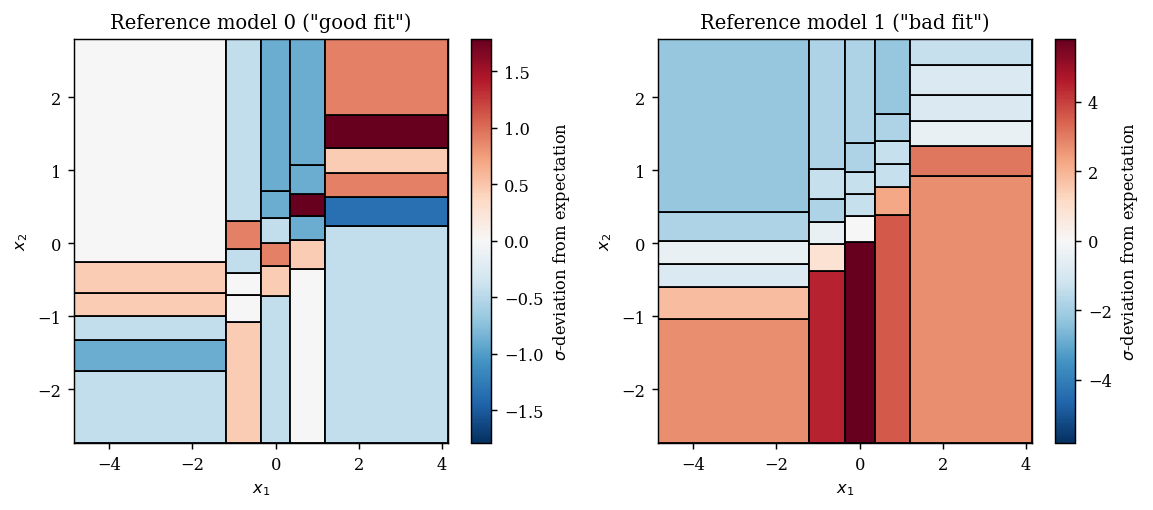

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# define eqpb parameters
order = [0, 1]  # [0, 1] means that first dimension 0 is binned, then dimension 1
n_partitions = [5, 6]  # 5 partitions in dim. 0 and 6 partitions in dim. 1

# perform GOF tests
for i, reference_sample in enumerate([reference_sample_0, reference_sample_1]):
    gof_object = ge.BinnedPoissonChi2GOF.bin_equiprobable(data_sample=data_sample,
                                                          reference_sample=reference_sample,
                                                          nevents_expected=n_expectations,
                                                          n_partitions=n_partitions,
                                                          order=order,
                                                          plot=True,
                                                          ax=axes[i]
                                                         )
    
    gof_object.get_pvalue()
    print(f'\033[1mReference {i}\033[0m')
    print(f'GOF = {gof_object.gof:.2f}')
    print(f'p-value = {gof_object.pvalue:.2f}\n')

axes[0].set_title('Reference model 0 ("good fit")')
axes[1].set_title('Reference model 1 ("bad fit")')

for ax in axes:
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
plt.tight_layout()

The visualisation of this equiprobabe binning can be useful to identify regions in which a fit doesn't agree with the data. For reference model 1 for example, the red bins in the lower part and the blue bins in the upper part clearly indicate that the reference model is shifted towards higher values of $x_2$ w.r.t the data.  
For the reference model 1, the precise p-value can't be calculated, since the MC-generated distribution of the test statistic under the null hypothesis only reaches to 63 while the observed value is 132.92. If higher precision is required, one can increase the `n_mc` parameter of the `.get_gof()` method, e.g. `.get_gof(n_mc=10_000)`. This "fit" however is so bad that even this will not suffice to cover the observed test statistic so for this tutorial, we are satisfied with knowing that the GOF test clearly rejects the "bad fit".

## 2. Perform multiple GOF tests at once

Finally, the GOFevaluation package features a wrapper function that can be used to conveniently perform multiple GOF tests at once. For this, simply initialize a `gof_object` with the data and reference in your desired format (note that you need to provide all formats that are required by all the tests you want to perform!). Then, similar to the single test case, you can use the method`.get_pvalues()` (note the s at the end of the methods!) to perform all GOF tests you defined in the `gof_list`.

In [10]:
# Initialise all binned GOF measures (with equiprobable binning):
gof_object = ge.GOFTest(data_sample=data_sample,
                        reference_sample=reference_sample_0,
                        nevents_expected=n_expectations,
                        n_partitions=[5, 6],
                        gof_list=['BinnedChi2GOF.bin_equiprobable', 
                                  'BinnedPoissonChi2GOF.bin_equiprobable'])
gof_object.get_pvalues()
print(gof_object)

GOFevaluation.gof_test
GOF measures: BinnedChi2GOF.bin_equiprobable, BinnedPoissonChi2GOF.bin_equiprobable


BinnedChi2GOF.bin_equiprobable
gof = 18.8
p-value = 0.935

BinnedPoissonChi2GOF.bin_equiprobable
gof = 18.57899301976094
p-value = 0.958

